In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using BenchmarkTools
using Distributions
using MacroTools
using LinearAlgebra

┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future warnings for GraphPPL are suppressed.


In [2]:
@model function transition_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) where { q = q(out, in)q(a) }
        x[t] ~ Transition(s[t], B) where { q = MeanField() }
        s_prev = s[t]
    end
    
    return s, x, A, B
end

transition_model (generic function with 1 method)

In [57]:
function inference(data, n_its)
    n = length(data)
    
    model, (s, x, A, B) = transition_model(n, options = (limit_stack_depth = 500, ))
    
    sbuffer = Vector{Vector{Marginal}}()
    Abuffer = Vector{Marginal}()
    Bbuffer = Vector{Marginal}()
    
    # fe_scheduler = PendingScheduler()
    
    ssub = subscribe!(collectLatest(getmarginals(s)), (ms) -> push!(sbuffer, ms))
    Asub = subscribe!(getmarginal(A), (mA) -> push!(Abuffer, mA))
    Bsub = subscribe!(getmarginal(B), (mB) -> push!(Bbuffer, mB))
    
    setmarginal!(A, vague(MatrixDirichlet, 3, 3))
    setmarginal!(B, vague(MatrixDirichlet, 3, 3))
    
    foreach(s) do svar
        setmarginal!(svar, vague(Categorical, 3))
    end
    
    # setmarginal!(γ, Gamma(0.01, 100.0))
    
    for i in 1:n_its
        update!(x, data)
        # release!(fe_scheduler)
    end
    
    unsubscribe!(ssub)
    unsubscribe!(Asub)
    unsubscribe!(Bsub)
    
    
    return sbuffer, Abuffer, Bbuffer
end

inference (generic function with 1 method)

In [4]:
import ForneyLab

function generate_data(n_samples)
    A_data = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] # Transition probabilities (some transitions are impossible)
    B_data = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] # Observation noise
    s_0_data = [1.0, 0.0, 0.0] # Initial state
    # Generate some data
    s_data = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x_data = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    s_t_min_data = s_0_data
    for t = 1:n_samples
        a = A_data*s_t_min_data
        s_data[t] = ForneyLab.sample(ForneyLab.ProbabilityDistribution(ForneyLab.Categorical, p=a./sum(a))) # Simulate state transition
        b = B_data*s_data[t]
        x_data[t] = ForneyLab.sample(ForneyLab.ProbabilityDistribution(ForneyLab.Categorical, p=b./sum(b))) # Simulate observation
        s_t_min_data = s_data[t]
    end
    ;
    return x_data, s_data
end

generate_data (generic function with 1 method)

In [115]:
x_data, s_data = generate_data(100);

In [116]:
@time sbuffer, Abuffer, Bbuffer = inference(x_data, 100);

  0.271676 seconds (2.15 M allocations: 165.379 MiB, 23.03% gc time)


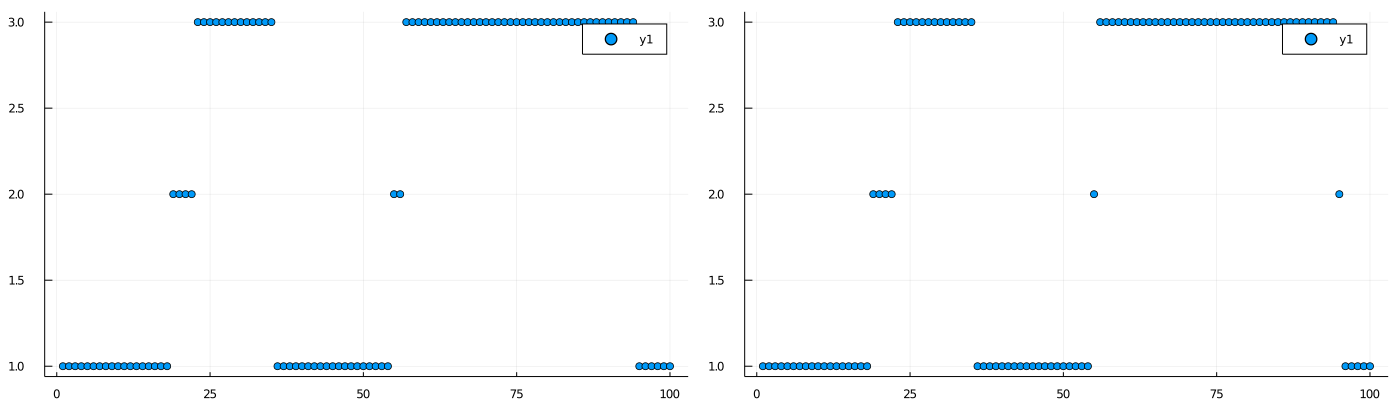

In [117]:
p1 = scatter(argmax.(s_data))
p2 = scatter(argmax.(ReactiveMP.probvec.(sbuffer[end])))

plot(p1, p2, size = (1400, 400))

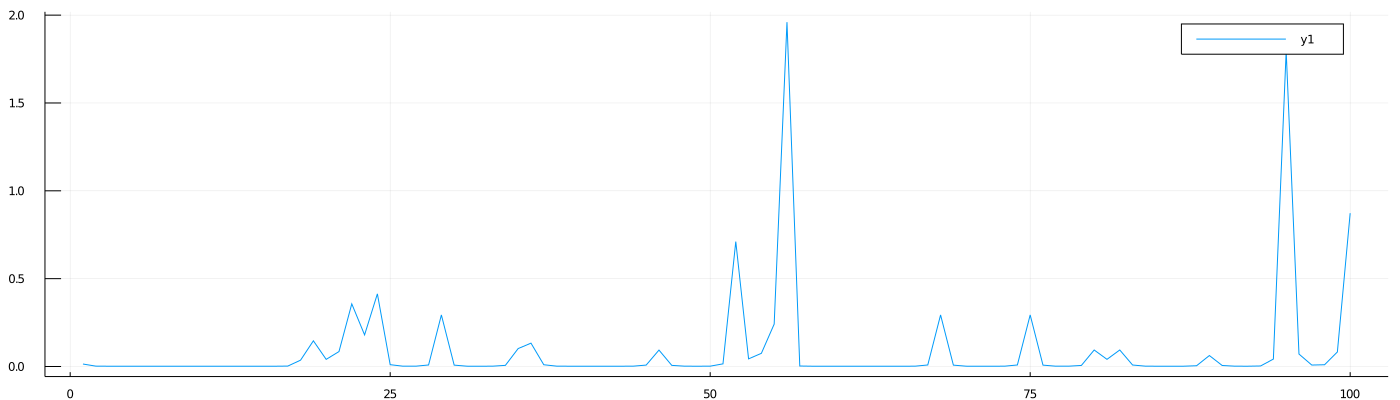

In [118]:
plot(sum.(map(a -> abs.(a), ReactiveMP.probvec.(sbuffer[end]) .- s_data)), size = (1400, 400))